# Rtst to Mask Automation Tutorial

**Step 1:** Import necessary packages & define necessary functions. 

*Just run these cells as they are.*

In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from rt_utils import RTStructBuilder

In [2]:
# Finds all RTStruct file paths in a given directory structure & organizes them by patient
def find_rtstructs(root_dir):
    patient_paths = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Look for an RT Structure file in a folder that seems to be an RTst folder
        if "RTst" in dirpath or any("RTst" in part for part in dirpath.split(os.sep)):
            for filename in filenames:
                if filename.endswith(".dcm"):
                    rt_struct_path = os.path.join(dirpath, filename)

                    # dicom_series_path is one folder above the RTst folder
                    rtst_folder = os.path.basename(dirpath)
                    one_above_rtst = os.path.dirname(dirpath)

                    # Get patient label as folder directly under root_dir
                    relative_path = os.path.relpath(one_above_rtst, root_dir)
                    patient_label = relative_path.split(os.sep)[0]

                    # Save paths and label
                    patient_paths.append({
                        "patient_label": patient_label,
                        "dicom_series_path": one_above_rtst,
                        "rt_struct_path": rt_struct_path
                    })
                    break  # stop after first DICOM file found in that RTst folder

    return patient_paths


In [3]:
# Build RTStruct objects from the patient paths
def build_rtstruct_objects(patient_paths):
    rtstruct_objects = []
    for p in patient_paths:
        rt = RTStructBuilder.create_from(
            dicom_series_path=p["dicom_series_path"],
            rt_struct_path=p["rt_struct_path"]
        )
        rtstruct_objects.append({
            "patient_label": p["patient_label"],
            "rtstruct": rt
        })
    return rtstruct_objects

In [4]:
def print_patient_rois(rtstruct_objects):
    for idx, obj in enumerate(rtstruct_objects):
        patient_label = obj["patient_label"]
        rtstruct = obj["rtstruct"]

        roi_names = rtstruct.get_roi_names()
        roi_list_str = ", ".join(roi_names)
        print(f"{idx}: {patient_label}: {roi_list_str}")

**Step 2:** Define your own path to your folder of patient data. Use 'find_rtstructs' function to find RTst file paths for each patient. Then, use 'build_rtstruct_objects' function to turn all of your RTst dicoms into RTutil objects. Finally, use the 'print_patient_rois' function to print out lists of each of all the ROI structures for each patient.

*The only thing you need to change here is the path to your patient folder.*

In [5]:
patient_root_folder_path = r"C:\Users\isabe\OneDrive\Desktop\Lauria Lab\ML Clinical Endpoint Prediction\Dosimetry"
patient_paths = find_rtstructs(patient_root_folder_path)
rtstruct_objects = build_rtstruct_objects(patient_paths)
print_patient_rois(rtstruct_objects)


0: Patient_0001: Spinal Cord, Outer Contour, trachea, LUL ITV, LUL PTV, Lung, Right, Heart, esophagus, Lung, Left, prox bronchus, Total Lung, 2 cm shell, Skin
1: Patient_0003: O_Vessel, O_Skin, PTV_ 2cm, CouchSurface, CouchInterior, NS_Artifact, O_Trca, P_RML_54, I_RML_54, O_Lung_Tt, O_Brnc, O_Chst_Wl, Body, O_Esgs, O_Lung_Lt, O_Hrt, O_Lung_Rt, O_Cord
2: Patient_0004: BODY, NS_Artifact, TS_High, TS_Low, O_Brnc, O_CW, PTV_5000, Union_ITV, PRV_Gvess, Great vess, ITV4, ITV3, ITV2, ITV1, O_Trca, O_Lung_R, O_Lung_Lt, O_Hrt, O_Esgs, O_Cord, CouchSurface, CouchInterior, O_Skin, TS_ITV, D2cm, O_Lung_Tt, O_Ribs


**Step 3:** Convert whatever ROI structure you want to convert into a mask from the printed list that outputs from Step 2. 
*Change the index number in the first set of brackets according to the printed list of outputs from Step 2. Then, copy the exact ROI name that you want to turn into a mask and paste into the "".*

In [7]:
mask = rtstruct_objects[0]["rtstruct"].get_roi_mask_by_name("LUL PTV")

**Step 4:** Check to make sure mask makes sense.

In [11]:
def find_max_slice(mask_3d):
    """Find the slice with the maximum amount of non-zero pixels."""
    # Count non-zero pixels in each slice
    nonzero_counts = [np.count_nonzero(mask_3d[i, :, :]) for i in range(mask_3d.shape[0])] # FOR DIFFERENT VIEWS: [CORONAL[0], SAGITTAL[1], AXIAL[2]]
    # Find the index of the slice with the maximum non-zero pixels
    max_slice_index = np.argmax(nonzero_counts)
    
    return max_slice_index

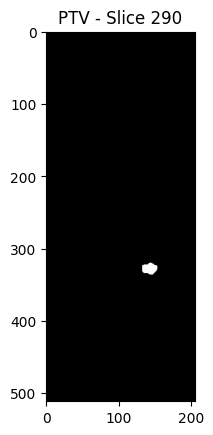

In [12]:
# Find the slice with the maximum number of nonzero pixels in the mask
max_PTV_slice = find_max_slice(mask)

# Display one slice of the region
plt.imshow(mask[max_PTV_slice, :, :], cmap='gray')
plt.title(f"PTV - Slice {max_PTV_slice}")
plt.show()